In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from zisnmf import ZISNMF, MyNMF
import torch
import torch.nn as nn


import os

# Set the CUDA device ID
cuda_device_id = 1  # Change this to the desired GPU ID
os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda_device_id)

# 加载FFHQ数据集
X, target = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

selected = np.random.choice(X.shape[0], 10000, replace=False)
X = X[selected]
target = target[selected]

X = MinMaxScaler().fit_transform(X)
n_samples, n_features = X.shape
target = target.astype(int)
n_classes = len(np.unique(target))



/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 设置参数
n_components = 100 
n_extra_states = 100
num_epochs = 100
learning_rate = 0.01
alpha = 0.2

# 运行zisnmf
zisnmf = ZISNMF(n_samples, n_features, n_classes, n_extra_states, zero_inflated=False, delta=0, device='cuda')

L = torch.zeros((n_samples, n_classes))
L[np.arange(n_samples), target] = 1.0  # 假设每个样本属于一个状态

M_zisnmf, V_zisnmf, W_zisnmf, H_zisnmf = zisnmf.fit_transform(torch.from_numpy(X).float(), L, num_epochs=num_epochs, 
                                                          learning_rate=learning_rate, alpha=alpha, batch_size=256)




Training: 100%|██████████| 100/100 [00:15<00:00,  6.37epoch/s, loss=4.8e+3]


In [3]:
# 运行NMF
nmf = NMF(n_components=n_components, max_iter=num_epochs, init='random')
W_nmf = nmf.fit_transform(X)
H_nmf = nmf.components_

#nmf = MyNMF(n_components)
#W_nmf, H_nmf = nmf.fit_transform(torch.from_numpy(X).float(), num_epochs=num_epochs, alpha=0, batch_size=64)

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


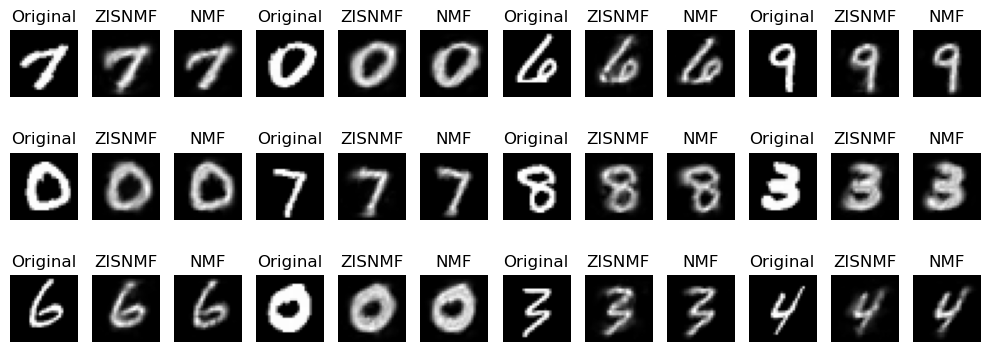

In [4]:
# 随机选择10张图片进行重建
indices = np.random.choice(n_samples, 12, replace=False)
X_selected = X[indices]

# 使用zisnmf重建图片
X_zisnmf_reconstructed = np.dot(M_zisnmf[indices], V_zisnmf) + np.dot(W_zisnmf[indices], H_zisnmf)

# 使用NMF重建图片
X_nmf_reconstructed = np.dot(W_nmf[indices], H_nmf)

# 可视化重建结果
fig, axes = plt.subplots(3, 12, figsize=(10, 4))
for i in range(3):
    axes[i, 0].imshow(X_selected[i].reshape(28,28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(X_zisnmf_reconstructed[i].reshape(28,28), cmap='gray')
    axes[i, 1].set_title('ZISNMF')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(X_nmf_reconstructed[i].reshape(28,28), cmap='gray')
    axes[i, 2].set_title('NMF')
    axes[i, 2].axis('off')

for i in range(3):
    axes[i, 3].imshow(X_selected[i+3].reshape(28,28), cmap='gray')
    axes[i, 3].set_title('Original')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(X_zisnmf_reconstructed[i+3].reshape(28,28), cmap='gray')
    axes[i, 4].set_title('ZISNMF')
    axes[i, 4].axis('off')
    
    axes[i, 5].imshow(X_nmf_reconstructed[i+3].reshape(28,28), cmap='gray')
    axes[i, 5].set_title('NMF')
    axes[i, 5].axis('off')

for i in range(3):
    axes[i, 6].imshow(X_selected[i+6].reshape(28,28), cmap='gray')
    axes[i, 6].set_title('Original')
    axes[i, 6].axis('off')
    
    axes[i, 7].imshow(X_zisnmf_reconstructed[i+6].reshape(28,28), cmap='gray')
    axes[i, 7].set_title('ZISNMF')
    axes[i, 7].axis('off')
    
    axes[i, 8].imshow(X_nmf_reconstructed[i+6].reshape(28,28), cmap='gray')
    axes[i, 8].set_title('NMF')
    axes[i, 8].axis('off')

for i in range(3):
    axes[i, 9].imshow(X_selected[i+9].reshape(28,28), cmap='gray')
    axes[i, 9].set_title('Original')
    axes[i, 9].axis('off')
    
    axes[i, 10].imshow(X_zisnmf_reconstructed[i+9].reshape(28,28), cmap='gray')
    axes[i, 10].set_title('ZISNMF')
    axes[i, 10].axis('off')
    
    axes[i, 11].imshow(X_nmf_reconstructed[i+9].reshape(28,28), cmap='gray')
    axes[i, 11].set_title('NMF')
    axes[i, 11].axis('off')

plt.tight_layout()
plt.show()


# Save the figure to an image file
#fig.savefig('mnist_reconstruct.png', dpi=300)  # Save with the same DPI as the figure

# Close the figure
#plt.close(fig)

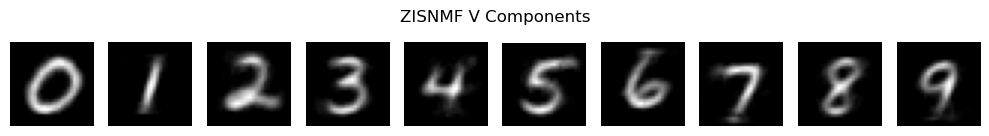

In [5]:
# 可视化zisnmf的V分量
fig, axes = plt.subplots(1, 10, figsize=(10, 4))
for j in range(10):
    axes[j].imshow(V_zisnmf[j].reshape(28,28), cmap='gray')
    axes[j].axis('off')
plt.suptitle('ZISNMF V Components', y=0.65)
plt.tight_layout()
plt.show()


# Save the figure to an image file
#fig.savefig('zisnmf_v_components.png', dpi=300)  # Save with the same DPI as the figure

# Close the figure
#plt.close(fig)


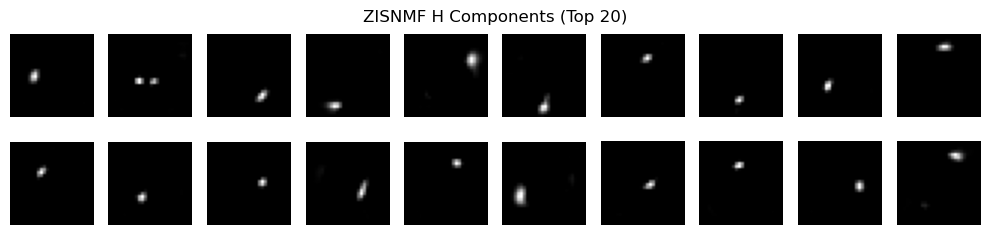

In [6]:
# 可视化ZISNMF的H分量
fig, axes = plt.subplots(2, 10, figsize=(10, 3))
for i in range(2):
    for j in range(10):
        axes[i, j].imshow(H_zisnmf[i*10+j].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('ZISNMF H Components (Top 20)', y=0.85)
plt.tight_layout()
plt.show()


# Save the figure to an image file
#fig.savefig('zisnmf_h_components.png', dpi=300)  # Save with the same DPI as the figure

# Close the figure
#plt.close(fig)

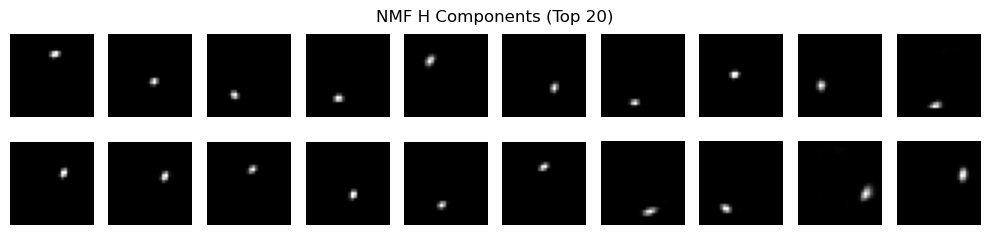

In [7]:
# 可视化NMF的H分量
fig, axes = plt.subplots(2, 10, figsize=(10, 3))
for i in range(2):
    for j in range(10):
        axes[i, j].imshow(H_nmf[i*10+j].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('NMF H Components (Top 20)', y=0.85)
plt.tight_layout()
plt.show()


# Save the figure to an image file
#fig.savefig('nmf_h_components.png', dpi=300)  # Save with the same DPI as the figure

# Close the figure
#plt.close(fig)